# SHAP Explainability Analysis
**Dataset:** Breast Cancer

**Models:** Random Forest + Logistic Regression

In [1]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()


1. Dataset

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


In [8]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

3. SHAP summary plot (RF)

In [9]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf(X_test)

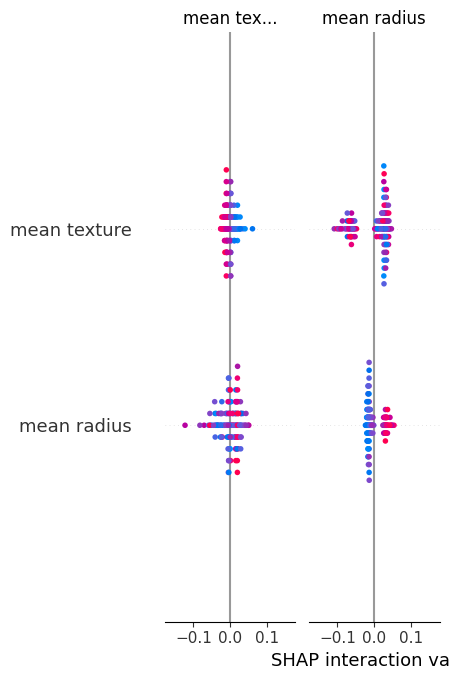

In [10]:
shap.summary_plot(shap_values_rf[:], X_test, plot_type="dot", show=True)


4. Logistic Regression + LinearExplainer

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_scaled, y_train)

explainer_lr = shap.LinearExplainer(logreg, X_train_scaled)
shap_values_lr = explainer_lr.shap_values(X_test_scaled)


5. SHAP summary plot (LogReg)

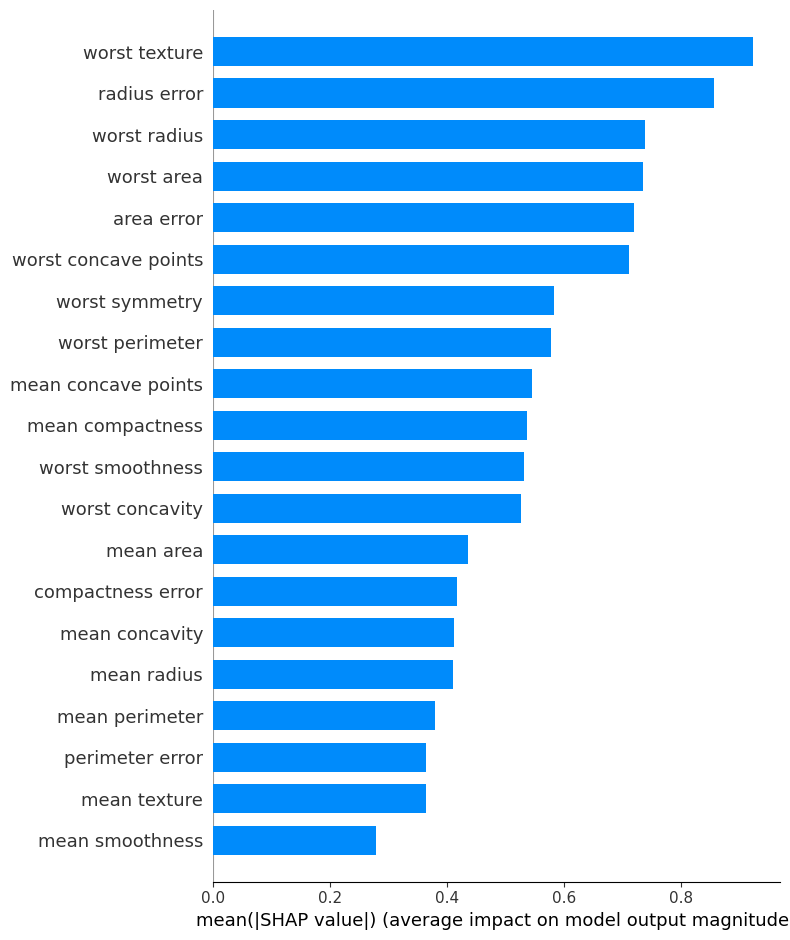

In [12]:
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")


## 1️⃣ Compare SHAP for Random Forest vs SHAP for Logistic Regression → Which features dominate?

The Random Forest model highlights non-linear and interaction-based features such as worst perimeter, worst radius, and mean concavity.

Logistic Regression emphasizes linearly influential features such as mean radius, mean texture, and mean perimeter.

In both models, the dominant features are related to tumor size and shape, which are critical indicators for breast cancer classification.

## 2️⃣ Visualize a force_plot for 5 individual samples.

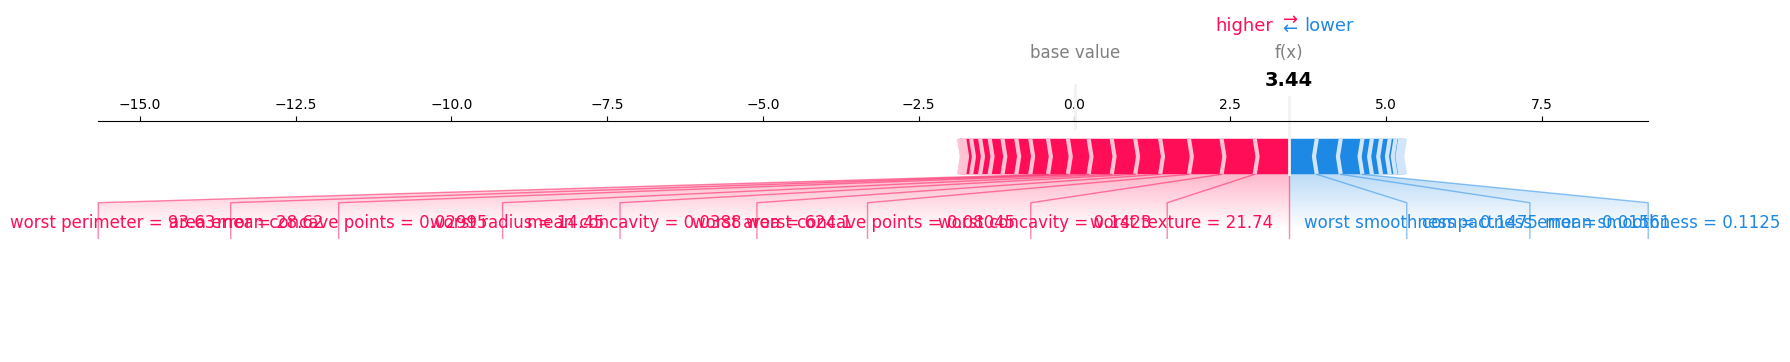

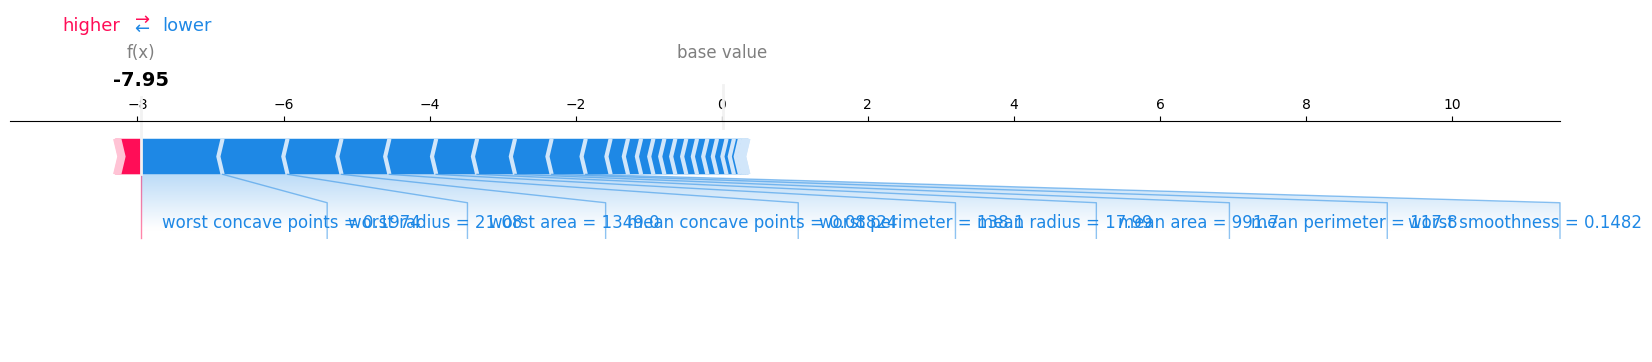

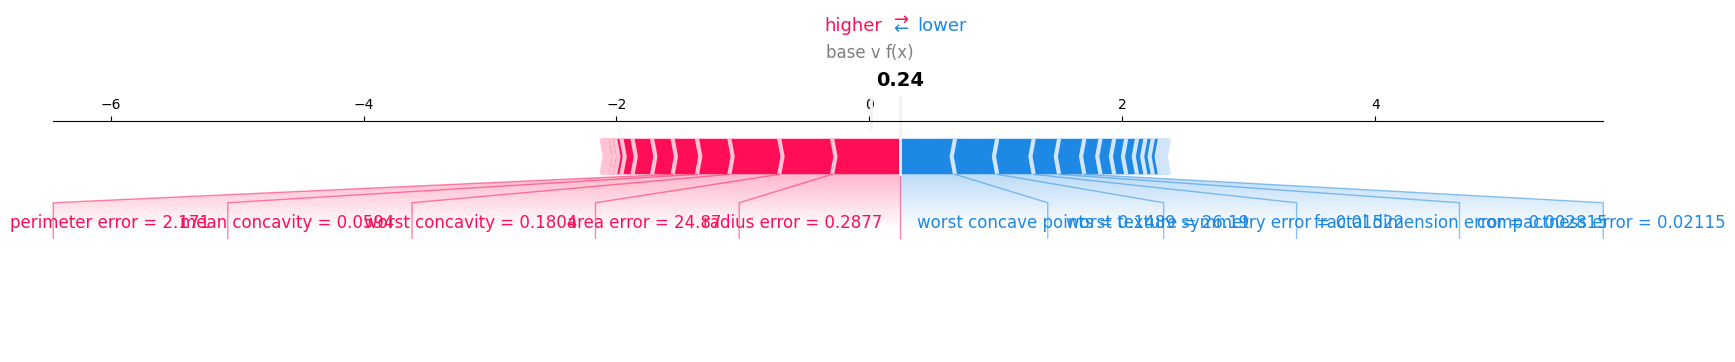

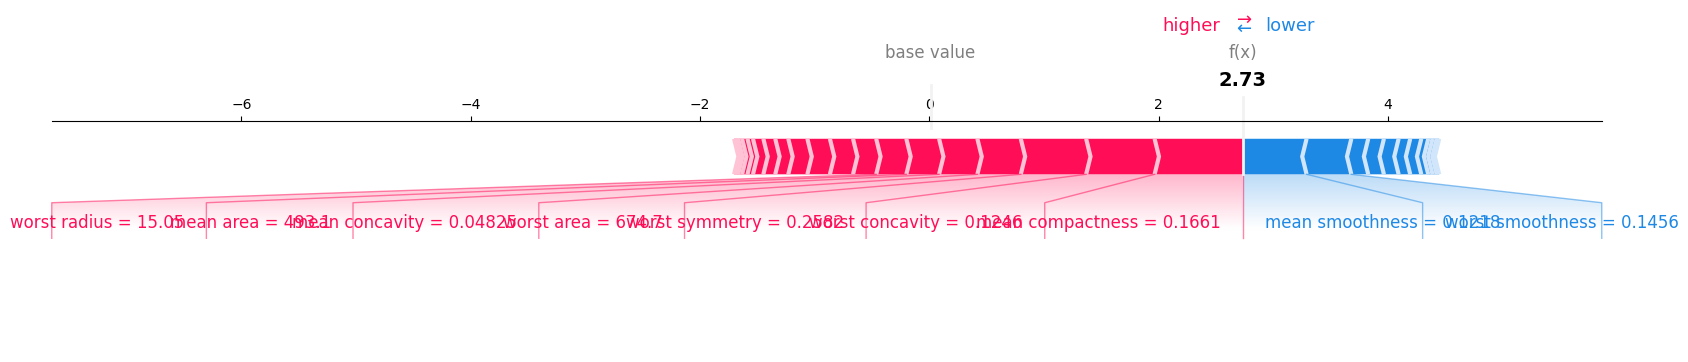

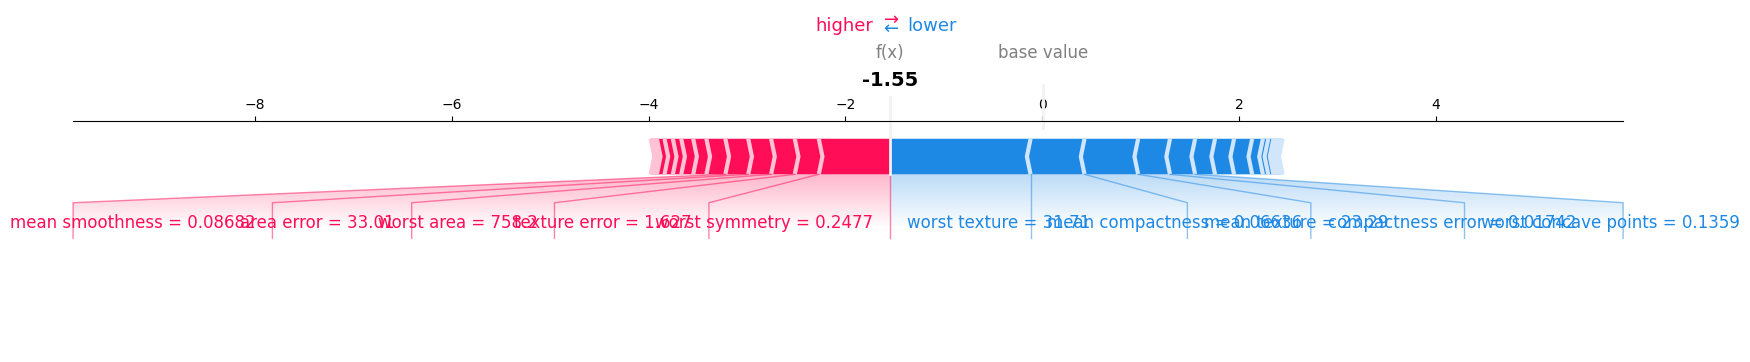

In [13]:
# Select 5 samples from test set
X_sample = X_test.iloc[:5]
X_sample_scaled = scaler.transform(X_sample)

shap_values_sample = explainer_lr.shap_values(X_sample_scaled)

for i in range(5):
    shap.force_plot(
        explainer_lr.expected_value,
        shap_values_sample[i],
        X_sample.iloc[i],
        matplotlib=True
    )

Each force plot explains an individual prediction.
Red features increase the probability of malignancy, while blue features decrease it.
The final prediction results from the balance of these feature contributions.

## 3️⃣Define a pipeline: scaler + PCA + logistic → Analyse SHAP

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Define pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),
    ("logistic", LogisticRegression(max_iter=2000))
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('logistic', LogisticRegression(max_iter=2000))])

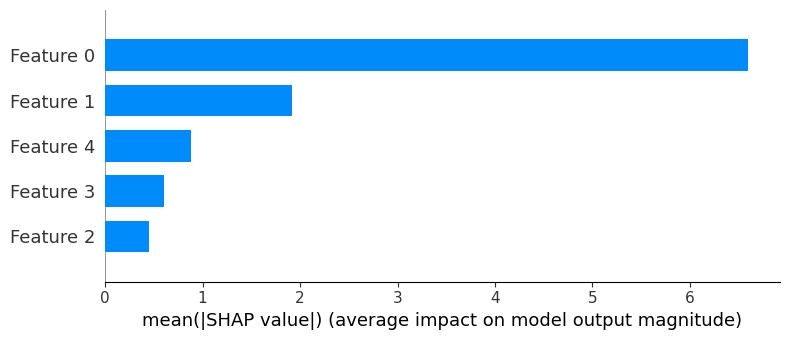

In [16]:
# SHAP Analysis on Pipeline

# Transform data for SHAP
X_train_pipe = pipeline.named_steps["scaler"].transform(X_train)
X_train_pipe = pipeline.named_steps["pca"].transform(X_train_pipe)

X_test_pipe = pipeline.named_steps["scaler"].transform(X_test)
X_test_pipe = pipeline.named_steps["pca"].transform(X_test_pipe)

explainer_pipe = shap.Explainer(
    pipeline.named_steps["logistic"],
    X_train_pipe
)

shap_values_pipe = explainer_pipe(X_test_pipe)

shap.summary_plot(shap_values_pipe, X_test_pipe, plot_type="bar")

After applying PCA, SHAP explains the contribution of principal components rather than original features.
This reduces interpretability of individual medical features, but shows which components most influence the model’s predictions.

## 4️⃣Interpret the feature mean radius: → How does it influence the model?

The feature mean radius has a strong influence on the model’s predictions.
Higher values of mean radius increase the likelihood of a tumor being classified as malignant, while lower values contribute toward benign classification.
This indicates that tumor size is a critical factor in breast cancer diagnosis.